# Dependencies

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import random
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score

print()
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU is {'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE'}")
print()

%matplotlib inline


TensorFlow version: 2.10.0
Keras version: 2.10.0
GPU is available



In [48]:
def resnet_block(x, filters, kernel_size=3, strides=1):
    """Basic ResNet block with two convolutional layers"""
    residual = x
    x = keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    if strides != 1 or residual.shape[-1] != filters:
        residual = keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(residual)
        residual = keras.layers.BatchNormalization()(residual)
    
    x = keras.layers.add([x, residual])
    x = keras.layers.Activation('relu')(x)
    
    return x

def resnet18():
    """Simple ResNet18 backbone for face recognition"""
    inputs = keras.Input(shape=(64, 64, 3))
    
    # Initial convolutional layer
    x = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    
    # ResNet blocks 2
    x = resnet_block(x, 128, strides=2)  # Downsample
    x = resnet_block(x, 128)
    
    # ResNet blocks 3
    x = resnet_block(x, 256, strides=2)  # Downsample
    x = resnet_block(x, 256)
    
    # ResNet blocks 4
    x = resnet_block(x, 512, strides=2)  # Downsample
    x = resnet_block(x, 512)

    # Global pooling and feature embedding
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(512, name='feature_embeddings')(x)  # 512-dim feature embeddings

    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Method 1: Metric Learning

## Triplet Dataset

In [5]:
class TripletFace(keras.utils.Sequence):
    """Dataset for triplet learning"""
    
    def __init__(self, image_dir, batch_size=16, image_size=(64, 64), seed=42):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size

        self.imgs_path = {
            person: os.listdir(os.path.join(image_dir, person)) for person in os.listdir(image_dir)
        }
        self.random = random.Random(seed)

        self.__produce_triplet_batches()

    def __produce_triplet_batches(self):
        self.triplets = []
        temp = []

        for person in self.imgs_path:
            anchor_paths = self.random.sample(self.imgs_path[person], len(self.imgs_path[person]) // 2)
            positive_paths = {*self.imgs_path[person]} - {*anchor_paths}
            for anchor, positive in zip(anchor_paths, positive_paths):
                anchor_img = os.path.join(self.image_dir, person, anchor)
                positive_img = os.path.join(self.image_dir, person, positive)
                negative_img = os.path.join(
                    self.image_dir,
                    negative_person := self.random.choice( list( {*self.imgs_path.keys()} - {person} ) ),
                    self.random.choice(self.imgs_path[negative_person])
                )
                temp.append((anchor_img, positive_img, negative_img))

        self.random.shuffle(temp)

        for i in range(0, len(temp), self.batch_size):
            self.triplets.append( temp[i:i + self.batch_size] )

    def __preprocess_image(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.image_size)
        image = keras.applications.resnet.preprocess_input(image)
        return image

    def on_epoch_end(self):
        self.__produce_triplet_batches()

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        batch = self.triplets[idx]
        anchor_paths, positive_paths, negative_paths = zip(*batch)
        return (
            tf.stack([self.__preprocess_image(path) for path in anchor_paths]),
            tf.stack([self.__preprocess_image(path) for path in positive_paths]),
            tf.stack([self.__preprocess_image(path) for path in negative_paths]),
        )

## Siamese Network Definition

In [6]:
def triplet_head(embedding):
    """Create triplet head for Siamese network"""
    anchor_input = keras.Input(name="anchor", shape=(64, 64, 3))
    positive_input = keras.Input(name="positive", shape=(64, 64, 3))
    negative_input = keras.Input(name="negative", shape=(64, 64, 3))

    anchor_embedding = embedding(anchor_input)
    positive_embedding = embedding(positive_input)
    negative_embedding = embedding(negative_input)

    return keras.Model(inputs=[anchor_input, positive_input, negative_input], 
                      outputs=[anchor_embedding, positive_embedding, negative_embedding])

In [7]:
class SiameseModel(keras.Model):
    """Siamese model for metric learning"""

    def __init__(self, embedding, loss="euclidean", margin=0.5):
        super().__init__()
        assert loss == "euclidean" or loss == "cosine", "loss must be either 'euclidean' or 'cosine'"
        self.siamese = triplet_head(embedding)
        self.loss_type = loss
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.auc_metric = keras.metrics.AUC(name="auc")

    def __distance(self, anchor, other):
        if self.loss_type == "euclidean":
            return tf.reduce_sum(tf.square(anchor - other), axis=-1)
        # Cosine distance
        return 1 + keras.losses.cosine_similarity(anchor, other)

    def __triplet_loss(self, ap_distance, an_distance):
        return tf.maximum(ap_distance - an_distance + self.margin, 0)

    def call(self, inputs):
        return self.siamese(inputs)

    def train_step(self, data):
        # Unpack the data - data is a tuple of (anchor, positive, negative)
        anchor_data, positive_data, negative_data = data
        
        with tf.GradientTape() as tape:
            # Forward pass through the model
            anchor, positive, negative = self.siamese([anchor_data, positive_data, negative_data])
            ap_distance = self.__distance(anchor, positive)
            an_distance = self.__distance(anchor, negative)
            loss = self.__triplet_loss(ap_distance, an_distance)

        # Compute gradients
        gradients = tape.gradient(loss, self.siamese.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.siamese.trainable_variables))

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.auc_metric.update_state(tf.ones_like(an_distance), an_distance)
        self.auc_metric.update_state(tf.zeros_like(ap_distance), ap_distance)

        return {"loss": self.loss_tracker.result(), "auc": self.auc_metric.result()}

    def test_step(self, data):
        # Unpack the data - data is a tuple of (anchor, positive, negative)
        anchor_data, positive_data, negative_data = data
        
        # Forward pass through the model
        anchor, positive, negative = self.siamese([anchor_data, positive_data, negative_data])
        ap_distance = self.__distance(anchor, positive)
        an_distance = self.__distance(anchor, negative)
        loss = self.__triplet_loss(ap_distance, an_distance)

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.auc_metric.update_state(tf.ones_like(an_distance), an_distance)
        self.auc_metric.update_state(tf.zeros_like(ap_distance), ap_distance)

        return {"loss": self.loss_tracker.result(), "auc": self.auc_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.auc_metric]

## Utility Functions

In [ ]:
def classification_head(embedding, num_classes):
    """Create classification head"""
    inputs = keras.Input(shape=(64, 64, 3))
    x = embedding(inputs)
    x = keras.layers.Dense(1000)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def distance_head(embedding, loss="euclidean"):
    """Create distance head for verification"""
    assert loss == "euclidean" or loss == "cosine", "loss must be either 'euclidean' or 'cosine'"

    input_x1 = keras.Input(name="input_x1", shape=(64, 64, 3))
    input_x2 = keras.Input(name="input_x2", shape=(64, 64, 3))

    x1_embedding = embedding(input_x1)
    x2_embedding = embedding(input_x2)

    if loss == "euclidean":
        distance = tf.reduce_sum(tf.square(x1_embedding - x2_embedding), axis=-1)
    else:
        distance = 1 - tf.reduce_sum(tf.nn.l2_normalize(x1_embedding, axis=-1) * tf.nn.l2_normalize(x2_embedding, axis=-1), axis=-1)

    return keras.Model(inputs=[input_x1, input_x2], outputs=distance)

In [ ]:
# Training Data

## Creating Triplet Datasets

In [10]:
triplets_dataset = TripletFace("data/classification_data/train_data")
val_triplets_dataset = TripletFace("data/classification_data/val_data")

## Visualizing Triplet Dataset

('data/classification_data/train_data\\n008752\\0329_01.jpg', 'data/classification_data/train_data\\n008752\\0192_01.jpg', 'data/classification_data/train_data\\n009102\\0062_01.jpg')


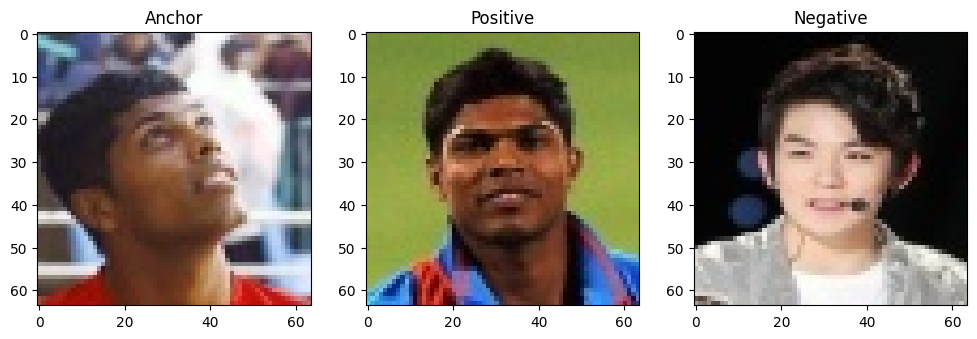

In [11]:
img_set = triplets_dataset.triplets[0][0]
print(img_set)
anchor, positive, negative = img_set
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(plt.imread(anchor))
axes[0].set_title('Anchor')
axes[1].imshow(plt.imread(positive))
axes[1].set_title('Positive')
axes[2].imshow(plt.imread(negative))
axes[2].set_title('Negative')
plt.savefig('saved_figures/triplet_visualization.png')
plt.show()

# Training Models

## A/ Train with Euclidean Distance Loss

### Model Initialization

In [12]:
embedding_euclidean = resnet18()

In [13]:
siamese_euclidean = SiameseModel(embedding_euclidean)

### Model Compilation and Training

In [14]:
siamese_euclidean.compile(optimizer=keras.optimizers.Adam(0.0001))

In [16]:
siamese_euclidean_history = siamese_euclidean.fit(
    triplets_dataset,
    validation_data=val_triplets_dataset,
    epochs=5,
    callbacks=[
        keras.callbacks.ModelCheckpoint("model_factory/model_siamese_euclidean.weights.keras", save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/5
11837/11837 [==============================] - 961s 81ms/step - loss: 0.8631 - auc: 0.6725 - val_loss: 0.2865 - val_auc: 0.7581
Epoch 2/5
11837/11837 [==============================] - 869s 73ms/step - loss: 0.2615 - auc: 0.7689 - val_loss: 0.2355 - val_auc: 0.7979
Epoch 3/5
11837/11837 [==============================] - 944s 80ms/step - loss: 0.2224 - auc: 0.8009 - val_loss: 0.2036 - val_auc: 0.8180
Epoch 4/5
11837/11837 [==============================] - 949s 80ms/step - loss: 0.2017 - auc: 0.8123 - val_loss: 0.1957 - val_auc: 0.8193
Epoch 5/5
11837/11837 [==============================] - 899s 76ms/step - loss: 0.1879 - auc: 0.8195 - val_loss: 0.1792 - val_auc: 0.8265


## B/ Train with Cosine Distance Loss

### Model Initialization

In [17]:
embedding_cosine = resnet18()

In [18]:
siamese_cosine = SiameseModel(embedding_cosine, loss="cosine", margin=1.0)

### Model Compilation and Training

In [19]:
siamese_cosine.compile(optimizer=keras.optimizers.Adam(0.0001))

In [21]:
siamese_cosine_history = siamese_cosine.fit(
    triplets_dataset,
    validation_data=val_triplets_dataset,
    epochs=5,
    callbacks=[
        keras.callbacks.ModelCheckpoint("model_factory/model_siamese_cosine.weights.keras", save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/5
11837/11837 [==============================] - 938s 79ms/step - loss: 0.6343 - auc: 0.7193 - val_loss: 0.5415 - val_auc: 0.7769
Epoch 2/5
11837/11837 [==============================] - 861s 73ms/step - loss: 0.5167 - auc: 0.7904 - val_loss: 0.4822 - val_auc: 0.8099
Epoch 3/5
11837/11837 [==============================] - 859s 73ms/step - loss: 0.4783 - auc: 0.8133 - val_loss: 0.4704 - val_auc: 0.8176
Epoch 4/5
11837/11837 [==============================] - 859s 73ms/step - loss: 0.4532 - auc: 0.8279 - val_loss: 0.4475 - val_auc: 0.8347
Epoch 5/5
11837/11837 [==============================] - 883s 75ms/step - loss: 0.4311 - auc: 0.8407 - val_loss: 0.4392 - val_auc: 0.8381


# Method 2: Classification

## Data

In [22]:
cls_train_dataset = keras.utils.image_dataset_from_directory(
    "data/classification_data/train_data",
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    batch_size=16
)
cls_val_dataset = keras.utils.image_dataset_from_directory(
    "data/classification_data/val_data",
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    batch_size=16
)

cls_train_dataset = cls_train_dataset.map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y))
cls_val_dataset = cls_val_dataset.map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y))

Found 380638 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.


## Classification Network Definition

In [28]:
import os

# Get number of classes from the dataset directory
num_classes = len(os.listdir("data/classification_data/train_data"))
print(f"Number of classes: {num_classes}")

Number of classes: 4000


## Model Initialization

In [29]:
embedding_classification = resnet18()

In [30]:
classification = classification_head(embedding_classification, num_classes)

## Model Compilation and Training

In [31]:
classification.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [32]:
classification_history = classification.fit(
    cls_train_dataset,
    validation_data=cls_val_dataset,
    epochs=10,
    callbacks=[
        keras.callbacks.ModelCheckpoint("model_factory/model_classification.weights.keras", save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/10
23790/23790 [==============================] - 294s 12ms/step - loss: 6.6928 - accuracy: 0.0308 - val_loss: 5.7037 - val_accuracy: 0.0695
Epoch 2/10
23790/23790 [==============================] - 293s 12ms/step - loss: 4.8382 - accuracy: 0.1476 - val_loss: 4.7200 - val_accuracy: 0.1769
Epoch 3/10
23790/23790 [==============================] - 291s 12ms/step - loss: 3.8945 - accuracy: 0.2631 - val_loss: 4.0588 - val_accuracy: 0.2691
Epoch 4/10
23790/23790 [==============================] - 287s 12ms/step - loss: 3.2636 - accuracy: 0.3546 - val_loss: 3.8061 - val_accuracy: 0.3061
Epoch 5/10
23790/23790 [==============================] - 298s 13ms/step - loss: 2.8072 - accuracy: 0.4265 - val_loss: 3.7640 - val_accuracy: 0.3249
Epoch 6/10
23790/23790 [==============================] - 299s 13ms/step - loss: 2.4482 - accuracy: 0.4837 - val_loss: 3.5312 - val_accuracy: 0.3586
Epoch 7/10
23790/23790 [==============================] - 352s 15ms/step - loss: 2.1462 - accuracy: 0.5350

# Evaluate

## Data

In [43]:
class FaceVerificationSet(keras.utils.Sequence):
    """Dataset for face verification evaluation"""

    def __init__(self, base_data_dir, pairs_text_path, batch_size=16, image_size=(64, 64), seed=42):
        self.base_data_dir = base_data_dir
        self.pairs_text_path = pairs_text_path
        self.batch_size = batch_size
        self.image_size = image_size

        self.batches = []

        with open(self.pairs_text_path, encoding="utf-8") as file:
            self.data = [
                {
                    "x1": os.path.join(base_data_dir, line.split(" ")[0]),
                    "x2": os.path.join(base_data_dir, line.split(" ")[1]),
                    "y": line.split(" ")[2]
                }
                for line in file.readlines()
            ]

        for i in range(0, len(self.data), self.batch_size):
            self.batches.append( self.data[i:i + self.batch_size] )

    def get_y(self):
        # for verification dataset, 1 means the same person, 0 means different persons
        # for roc auc score, we need to return 0 for the same person, 1 for different persons
        return [1 - int(data["y"]) for data in self.data]

    def __preprocess_image(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.image_size)
        image = keras.applications.resnet.preprocess_input(image)
        return image

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        batch = self.batches[idx]
        return [(
            tf.stack([self.__preprocess_image(data["x1"]) for data in batch]),
            tf.stack([self.__preprocess_image(data["x2"]) for data in batch])
        )]

In [44]:
data_verification = FaceVerificationSet('data', 'data/verification_pairs_val.txt')

## Models

### Reload Models and Add Distance Heads

In [83]:
# Create a new empty directory for saving the models
if not os.path.exists("model_factory/new_models"):
    os.makedirs("model_factory/new_models")

# Instead of loading pretrained weights, let's use the trained models directly
print("Using trained models from training phase")

Using trained models from training phase


In [84]:
embedding_euclidean.save("model_factory/new_models/embedding_euclidean.keras")

In [85]:
embedding_cosine.save("model_factory/new_models/embedding_cosine.keras")

In [87]:
embedding_classification.save("model_factory/new_models/embedding_classification.keras")

### Add Distance Head for Validation

In [88]:
siamese_euclidean_distance = distance_head(embedding_euclidean)
siamese_cosine_distance = distance_head(embedding_cosine, loss="cosine")
classification_distance = distance_head(embedding_classification)

## Evaluation

### Perform Predictions on Verification Data

In [89]:
siamese_euclidean_preds = siamese_euclidean_distance.predict(data_verification)
siamese_cosine_preds = siamese_cosine_distance.predict(data_verification)
classification_preds = classification_distance.predict(data_verification)

551/551 [==============================] - 28s 50ms/step


### Calculate Metrics

ROC Curve (Receiver Operating Characteristic)

In [90]:
siamese_euclidean_fpr, siamese_euclidean_tpr, siamese_euclidean_thresholds = roc_curve(data_verification.get_y(), siamese_euclidean_preds)
siamese_cosine_fpr, siamese_cosine_tpr, siamese_cosine_thresholds = roc_curve(data_verification.get_y(), siamese_cosine_preds)
classification_fpr, classification_tpr, classification_thresholds = roc_curve(data_verification.get_y(), classification_preds)

AUC Score (Area Under the Curve)

In [91]:
siamese_euclidean_auc = roc_auc_score(data_verification.get_y(), siamese_euclidean_preds)
siamese_cosine_auc = roc_auc_score(data_verification.get_y(), siamese_cosine_preds)
classification_auc = roc_auc_score(data_verification.get_y(), classification_preds)

print(f"Siamese Euclidean AUC: {siamese_euclidean_auc:.4f}")
print(f"Siamese Cosine AUC: {siamese_cosine_auc:.4f}")
print(f"Classification AUC: {classification_auc:.4f}")

Siamese Euclidean AUC: 0.8187
Siamese Cosine AUC: 0.7931
Classification AUC: 0.8388


### Plot ROC Curves

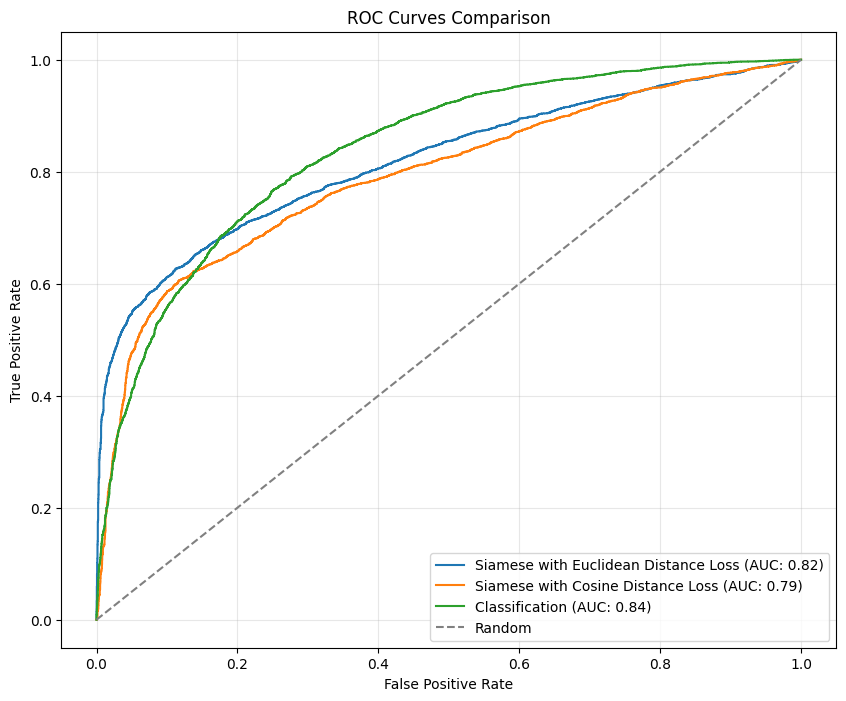

In [92]:
plt.figure(figsize=(10, 8))
plt.plot(siamese_euclidean_fpr, siamese_euclidean_tpr, label=f"Siamese with Euclidean Distance Loss (AUC: {siamese_euclidean_auc:.2f})")
plt.plot(siamese_cosine_fpr, siamese_cosine_tpr, label=f"Siamese with Cosine Distance Loss (AUC: {siamese_cosine_auc:.2f})")
plt.plot(classification_fpr, classification_tpr, label=f"Classification (AUC: {classification_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('saved_figures/roc_curves_comparison.png')
plt.show()

### Find Optimal Thresholds

In [93]:
siamese_euclidean_best_threshold_idx = np.argmax(siamese_euclidean_tpr - siamese_euclidean_fpr)
print(f"Siamese with Euclidean Distance Loss best threshold: {siamese_euclidean_thresholds[siamese_euclidean_best_threshold_idx]:.4f}")
print(f"Siamese with Euclidean Distance Loss best fpr: {siamese_euclidean_fpr[siamese_euclidean_best_threshold_idx]:.4f}")
print(f"Siamese with Euclidean Distance Loss best tpr: {siamese_euclidean_tpr[siamese_euclidean_best_threshold_idx]:.4f}")

Siamese with Euclidean Distance Loss best threshold: 1.2474
Siamese with Euclidean Distance Loss best fpr: 0.1122
Siamese with Euclidean Distance Loss best tpr: 0.6269


In [94]:
siamese_cosine_best_threshold_idx = np.argmax(siamese_cosine_tpr - siamese_cosine_fpr)
print(f"Siamese with Cosine Distance Loss best threshold: {siamese_cosine_thresholds[siamese_cosine_best_threshold_idx]:.4f}")
print(f"Siamese with Cosine Distance Loss best fpr: {siamese_cosine_fpr[siamese_cosine_best_threshold_idx]:.4f}")
print(f"Siamese with Cosine Distance Loss best tpr: {siamese_cosine_tpr[siamese_cosine_best_threshold_idx]:.4f}")

Siamese with Cosine Distance Loss best threshold: 0.9264
Siamese with Cosine Distance Loss best fpr: 0.1166
Siamese with Cosine Distance Loss best tpr: 0.6051


In [95]:
classification_best_threshold_idx = np.argmax(classification_tpr - classification_fpr)
print(f"Classification best threshold: {classification_thresholds[classification_best_threshold_idx]:.4f}")
print(f"Classification best fpr: {classification_fpr[classification_best_threshold_idx]:.4f}")
print(f"Classification best tpr: {classification_tpr[classification_best_threshold_idx]:.4f}")

Classification best threshold: 456.7885
Classification best fpr: 0.2484
Classification best tpr: 0.7653


### Training History Visualization

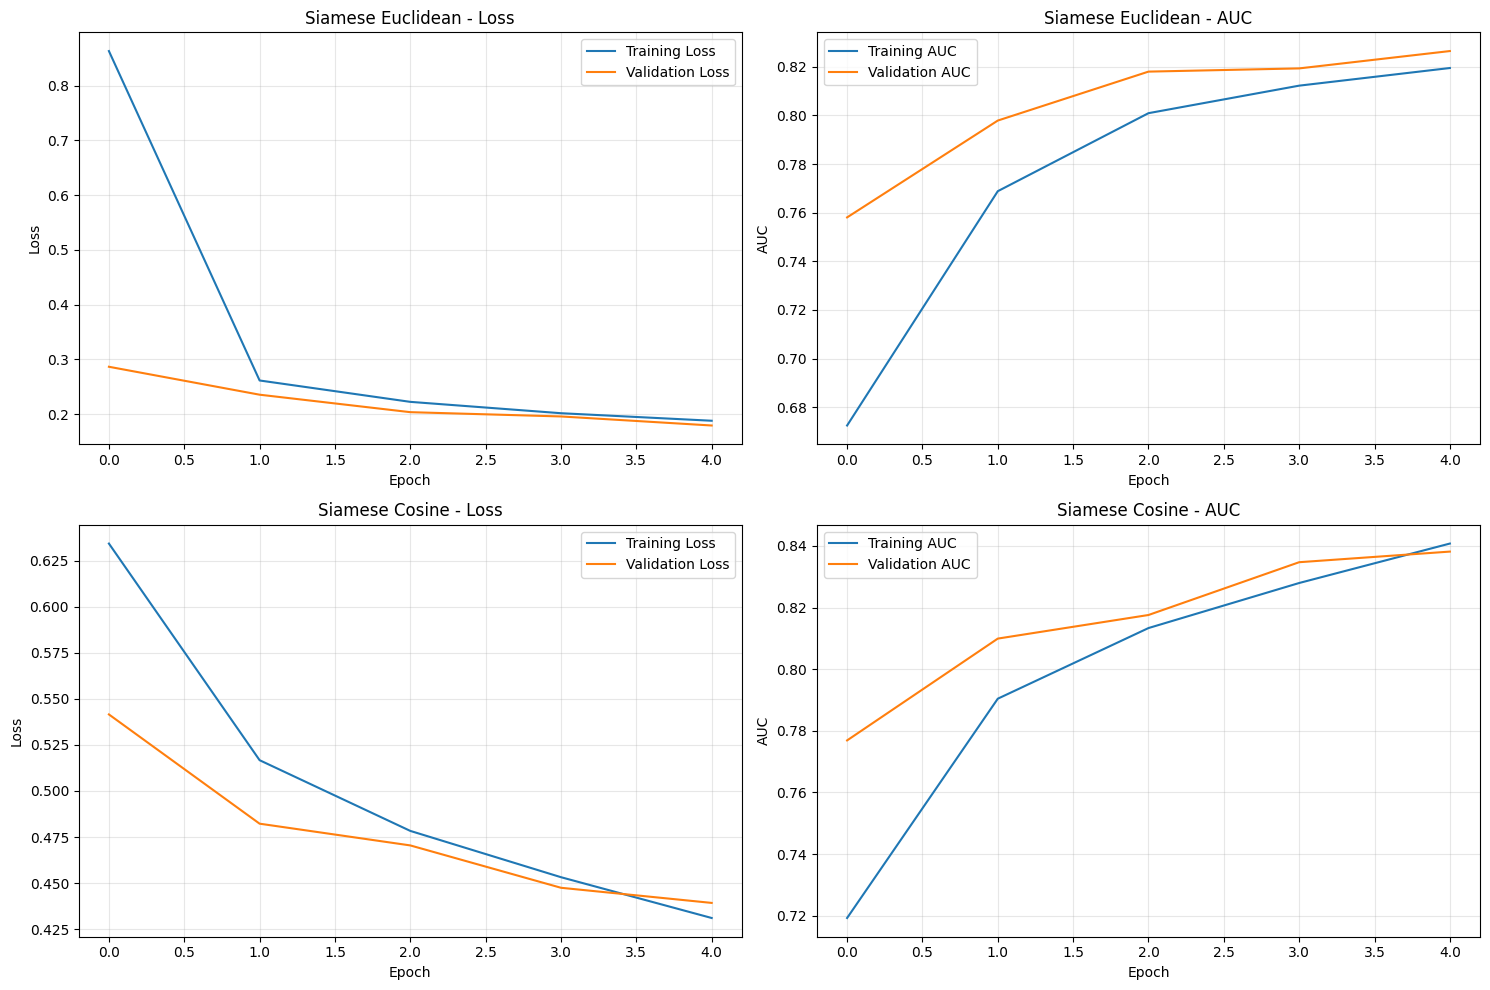

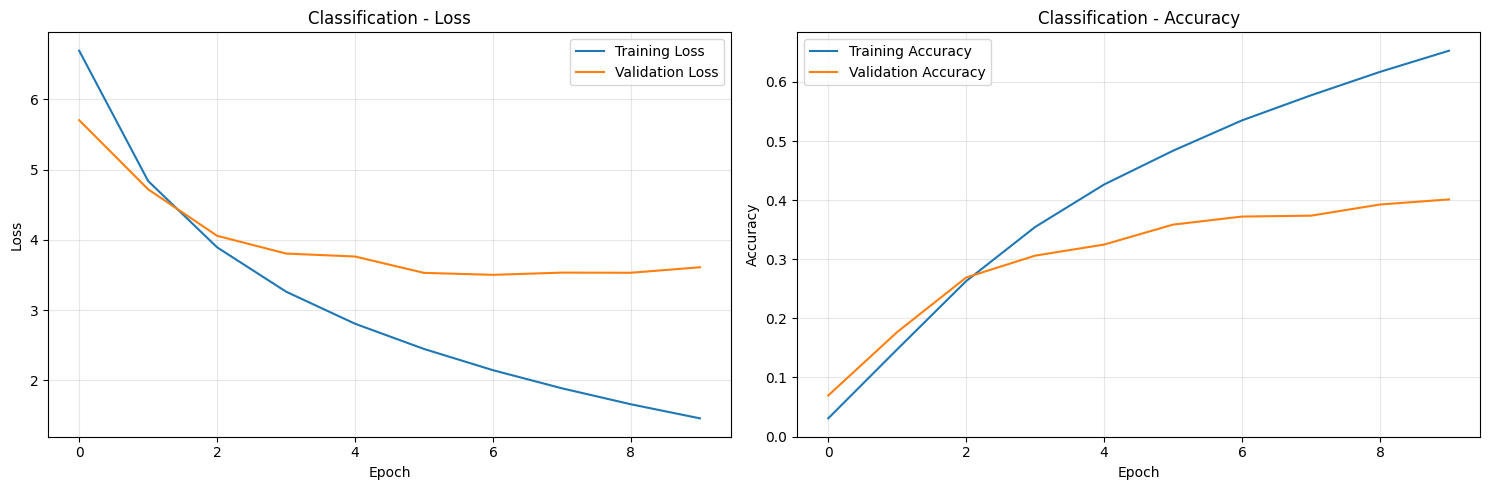

In [99]:
# Plot training histories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Euclidean loss
axes[0, 0].plot(siamese_euclidean_history.history['loss'], label='Training Loss')
axes[0, 0].plot(siamese_euclidean_history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Siamese Euclidean - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Euclidean AUC
axes[0, 1].plot(siamese_euclidean_history.history['auc'], label='Training AUC')
axes[0, 1].plot(siamese_euclidean_history.history['val_auc'], label='Validation AUC')
axes[0, 1].set_title('Siamese Euclidean - AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cosine loss
axes[1, 0].plot(siamese_cosine_history.history['loss'], label='Training Loss')
axes[1, 0].plot(siamese_cosine_history.history['val_loss'], label='Validation Loss')
axes[1, 0].set_title('Siamese Cosine - Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cosine AUC
axes[1, 1].plot(siamese_cosine_history.history['auc'], label='Training AUC')
axes[1, 1].plot(siamese_cosine_history.history['val_auc'], label='Validation AUC')
axes[1, 1].set_title('Siamese Cosine - AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saved_figures/siamese_models_training_history.png')
plt.show()

# Classification accuracy
if 'accuracy' in classification_history.history:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(classification_history.history['loss'], label='Training Loss')
    plt.plot(classification_history.history['val_loss'], label='Validation Loss')
    plt.title('Classification - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(classification_history.history['accuracy'], label='Training Accuracy')
    plt.plot(classification_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Classification - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('saved_figures/classification_model_training_history.png')
    plt.show()